<a href="https://colab.research.google.com/github/uswatnkh07/Demand-Forcasting-And-Safety-Stock-Management/blob/main/2209116010_Uswatun_Khasanah_Demand_Forcasting_And_Safety_Stock_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   **Nama: Uswatun Khasanah**

*   **NIM: 2209116010**
*   **Kelas: Sistem Informasi (A 2022)**


*   **Mata Kuliah: Penggalian Data dan Analitika Bisnis**



# ✨Safety Stock Optimization to Provide Desired Service Level for Stochastic Demand✨

### Inventory Policy:
Kebijakan persediaan adalah prosedur operasi standar untuk menerapkan model persediaan. Jelas bahwa model persediaan bergantung pada kebijakan persediaan yang dipilih. Dalam penerapan ini, digunakan kebijakan persediaan **(Q, R)**.

Di bawah kebijakan ini, tingkat persediaan dipantau secara terus menerus. Ketika tingkat persediaan turun di bawah ambang batas yang telah ditentukan sebelumnya (R), yang dikenal sebagai **Titik Pemesanan Kembali (ROP)**, pesanan pengisian ulang dengan jumlah tetap (Q), yang dikenal sebagai **Kuantitas Pemesanan Ekonomis (EOQ)**, dilakukan. Dalam masalah optimasi persediaan ini, terdapat dua variabel keputusan, yaitu Q dan R. Berikut gambar penjelasannya:

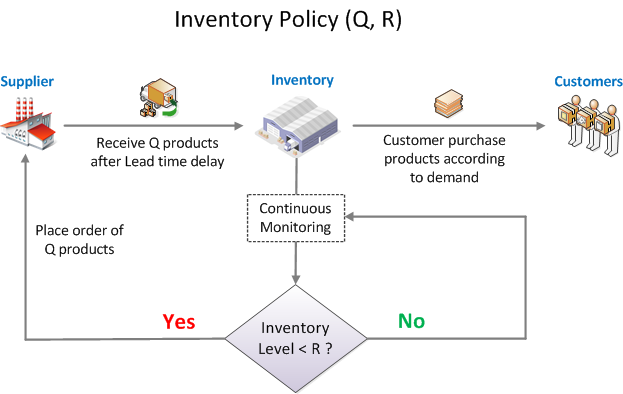

Optimasi persediaan memerlukan jawaban atas dua pertanyaan:

1. Kapan harus membeli (R)?

2. Berapa banyak yang harus dibeli (Q)?

- **Economic Order Quantity (EOQ):**
Jumlah pesanan yang sebaiknya dibeli perusahaan untuk persediaannya guna meminimalkan total biaya persediaan, seperti biaya penyimpanan dan biaya pemesanan.

- **Reorder Point (ROP):**
Tingkat persediaan di mana pesanan baru harus dilakukan.

- **Lead Time:**
Jangka waktu antara pemesanan dan penerimaan produk yang dipesan.

Jika permintaan bersifat **deterministik** sempurna, maka ROP dapat dihitung dengan mudah.
<h3><center>ROP = Demand during Lead time</center></h3

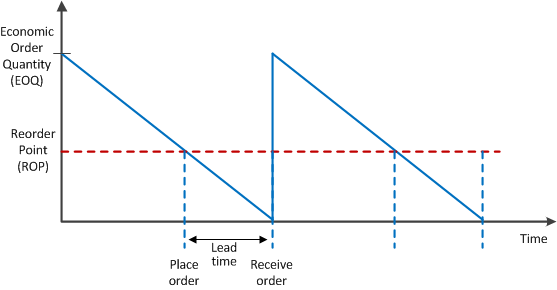


Jika permintaan bersifat **stokastik**, maka perhitungan ROP menjadi lebih kompleks. Jika permintaan selama lead time kurang dari yang diharapkan, akan ada persediaan saat pesanan diterima. Namun, jika permintaan selama lead time lebih dari yang diharapkan, akan terjadi kekurangan persediaan sebelum pesanan diterima dan layanan akan terganggu.

Selain itu, jika lead time juga menjadi stokastik, situasinya akan menjadi lebih buruk.

<h3><center>ROP = Mean demand during Lead time</center></h3

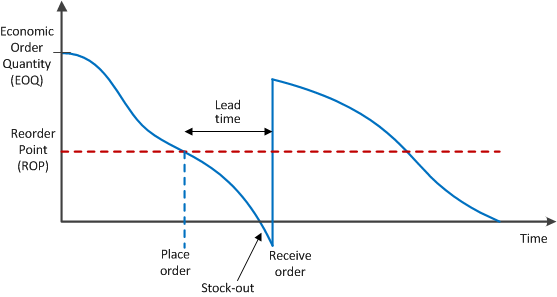

Untuk mencegah kekurangan persediaan, kita menyimpan tambahan stok yang dikenal sebagai **'stok pengaman (SS)'** guna meningkatkan ROP.

ROP is then calculated as:
<h3><center>ROP = Mean demand during Lead time + SS</center></h3



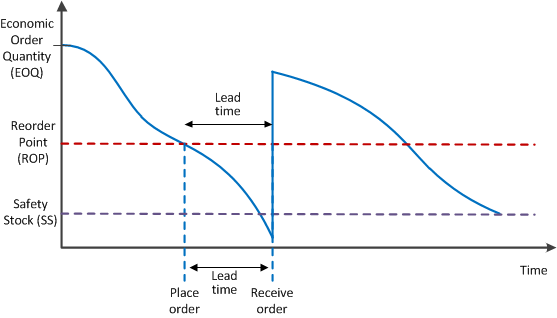



The calculation of safety stock (SS) depends on service level. Service level is a metric to quantify the level of stockouts that can be tolerated in order to meet the desired level of customer satisfaction.

If  $\,\alpha = P\,(\text{stockout})$, then the service level is defined as:

$$\text{Service level} = (1-\alpha) = \dfrac{\text{Quantity of products delivered}}{\text{Total quantity demanded}}$$

Selain tingkat layanan, jumlah **Safety stock (SS)** juga bergantung pada:

1. Permintaan harian acak yang dilambangkan dengan variabel acak $D_i$, dimana $i$ menunjukkan hari.

2. Lead time acak yang dilambangkan dengan variabel acak $L$.

**Assumptions:**

1. Permintaan harian $D_i$ adalah variabel normal yang identik dan terdistribusi independen (i.i.d) dengan $D_i\sim\mathcal{N}(\mu_D, \sigma_D^2)$

2. Lead time $L$ adalah variabel normal dengan $L\sim\mathcal{N}(\mu_L, \sigma_L^2)$

3. Permintaan harian pribadi dari lead time.

where,
 - $\mu_D$ = Nilai rata-rata permintaan harian

 - $\sigma_D^2$ = Varian permintaan harian

 - $\mu_L$ =  Nilai rata-rata lead time

 - $\sigma_L^2$ = Varian lead time

<h2><center>Demand Forcasting</center></h2>

In [42]:
import warnings
import itertools
from math import *
import numpy as np
import pandas as pd
from scipy.stats import *
import statsmodels.api as sm
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')
from datetime import datetime

In [43]:
url = 'https://github.com/uswatnkh07/Demand-Forcasting-And-Safety-Stock-Management/raw/main/demand_data.xlsx'
demand_df = pd.read_excel(url)
demand_df['Date'] = pd.to_datetime(demand_df['Date'], format='%Y%m%d')
demand_df.set_index('Date', inplace=True)

In [44]:
demand_df.head(3)

,Daily_Demand
Date,
2014-01-01,7
2014-01-02,9
2014-01-03,9


In [45]:
# Resample the demand data in monthly interval
demand_ts = demand_df['Daily_Demand'].resample('MS').mean()
demand_ts.head(10)

Date
2014-01-01    6.741935
2014-02-01    6.642857
2014-03-01    7.419355
2014-04-01    6.500000
2014-05-01    7.096774
2014-06-01    6.066667
2014-07-01    6.774194
2014-08-01    6.580645
2014-09-01    7.166667
2014-10-01    7.032258
Freq: MS, Name: Daily_Demand, dtype: float64

<h3><center>Three Components of a Time Series</center></h3>

 - **Trend:**
Peningkatan atau penurunan jangka panjang dalam data yang mungkin tidak linier. Kadang-kadang tren bisa berubah seiring waktu.


 - **Seasonality:**
Kadang-kadang sebuah deret waktu menunjukkan fluktuasi teratur berdasarkan musim (misalnya, setiap minggu/bulan/tahun). Musiman selalu memiliki periode yang tetap dan diketahui.


 - **Noise/ Residual:**
Variasi acak dalam deret waktu setelah menghilangkan komponen tren dan musiman.

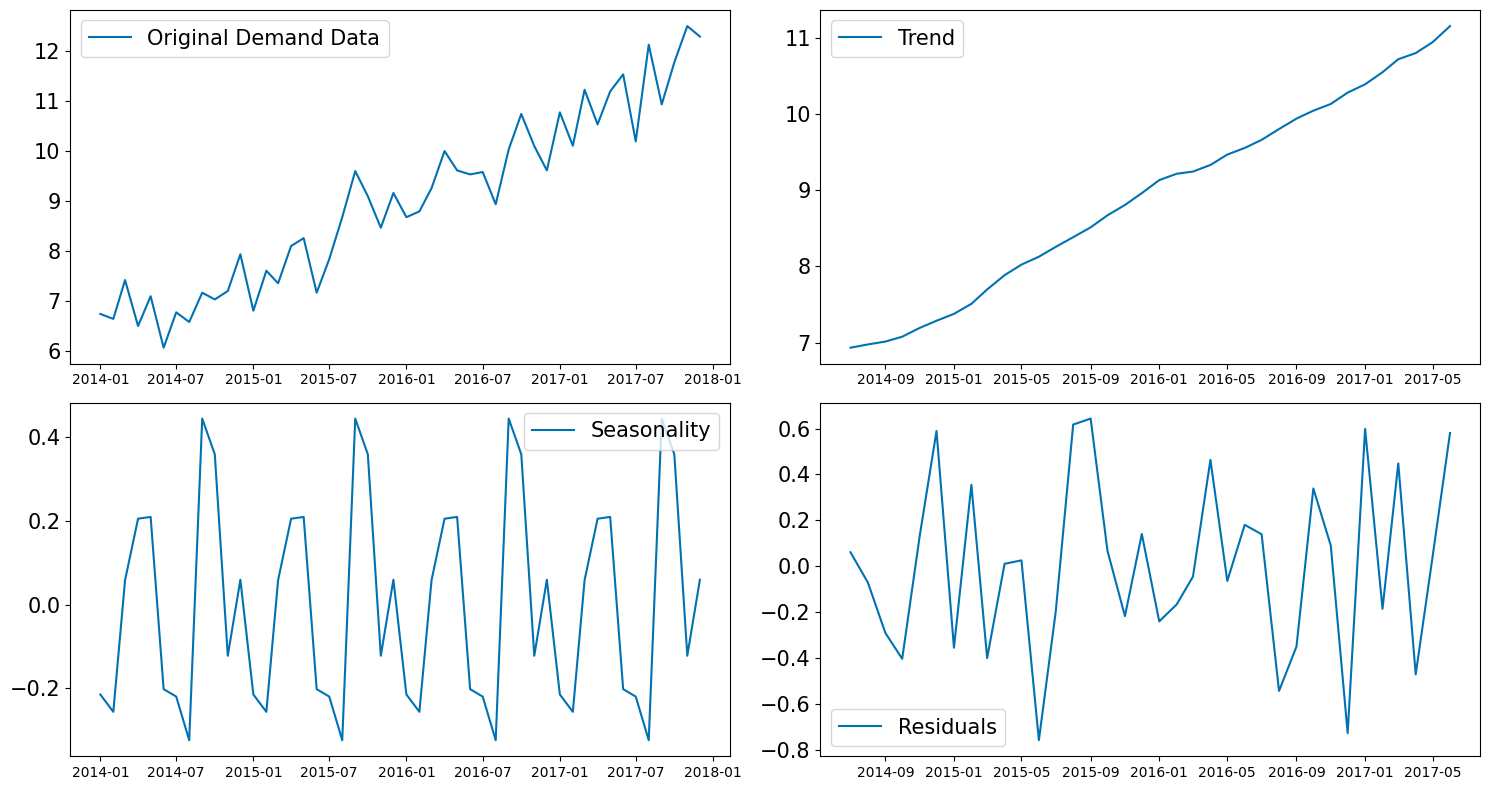

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(demand_ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 8))

plt.subplot(2,2,1)
plt.plot(demand_ts, label='Original Demand Data')
plt.legend(loc='best', fontsize = 15)
plt.tick_params(axis='y', which='major', labelsize=15)

plt.subplot(2,2,2)
plt.plot(trend, label='Trend')
plt.legend(loc='best', fontsize = 15)
plt.tick_params(axis='y', which='major', labelsize=15)

plt.subplot(2,2,3)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best', fontsize = 15)
plt.tick_params(axis='y', which='major', labelsize=15)

plt.subplot(2,2,4)
plt.plot(residual, label='Residuals')
plt.legend(loc='best', fontsize = 15)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.tight_layout()

Dataset untuk permintaan diberikan dari Januari 2014 hingga Desember 2017. Kami perlu memprediksi permintaan untuk seluruh tahun 2018, yaitu dari Januari 2018 hingga Desember 2018. Pertama, kami memprediksi permintaan untuk tahun 2017 dan membandingkan nilai prediksi dengan nilai aktual untuk mendapatkan perkiraan akurasi model. Kemudian kami memprediksi untuk tahun 2018.

<h2><center>ARIMA Time Series Model</center></h2>

Salah satu metode yang paling umum digunakan dalam peramalan deret waktu dikenal sebagai model ARIMA, yang merupakan singkatan dari Autoregressive Integrated Moving Average. Model ARIMA ini ditandai dengan notasi **ARIMA$(p, d, q)$** di mana tiga bilangan bulat berbeda $(p, d, q)$ digunakan untuk memparametrikkan model ARIMA.


- $p$ adalah parameter **auto-regresif**. Ini memungkinkan kita untuk memasukkan efek dari nilai-nilai masa lalu ke dalam model kita.

- $d$ adalah bagian **terintegrasi**. Ini memungkinkan kita untuk memasukkan jumlah differencing ke dalam deret waktu.

- $q$ adalah parameter **rata-rata bergerak**. Ini memungkinkan kita untuk menetapkan kesalahan model kita sebagai kombinasi linear dari nilai-nilai kesalahan yang diamati pada titik waktu sebelumnya di masa lalu.

Ketika menangani efek musiman, kita menggunakan ARIMA musiman, yang ditandai sebagai ARIMA $(p,d,q) (P,D,Q)_m$. Di sini, $(p, d, q)$ adalah parameter non-musiman seperti yang dijelaskan di atas, sedangkan $(P, D, Q)$ mengikuti definisi yang sama tetapi diterapkan pada komponen musiman dari deret waktu. Istilah $m$ adalah periodisitas dari deret waktu.

In [47]:
# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q, and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q, and q triplets
m = 12
seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]

ARIMA(0, 0, 0)x(0, 0, 0, 12);  AIC:10719.7372
ARIMA(0, 0, 0)x(0, 0, 1, 12);  AIC:9542.8847
ARIMA(0, 0, 0)x(0, 1, 0, 12);  AIC:7908.2546
ARIMA(0, 0, 0)x(0, 1, 1, 12);  AIC:6941.8182
ARIMA(0, 0, 0)x(1, 0, 0, 12);  AIC:7865.5284
ARIMA(0, 0, 0)x(1, 0, 1, 12);  AIC:6922.8966
ARIMA(0, 0, 0)x(1, 1, 0, 12);  AIC:7404.8287
ARIMA(0, 0, 0)x(1, 1, 1, 12);  AIC:6943.7682
ARIMA(0, 0, 1)x(0, 0, 0, 12);  AIC:9580.9191
ARIMA(0, 0, 1)x(0, 0, 1, 12);  AIC:8957.1490
ARIMA(0, 0, 1)x(0, 1, 0, 12);  AIC:7904.7915
ARIMA(0, 0, 1)x(0, 1, 1, 12);  AIC:6937.0084
ARIMA(0, 0, 1)x(1, 0, 0, 12);  AIC:7862.2461
ARIMA(0, 0, 1)x(1, 0, 1, 12);  AIC:6919.7808
ARIMA(0, 0, 1)x(1, 1, 0, 12);  AIC:7406.7132
ARIMA(0, 0, 1)x(1, 1, 1, 12);  AIC:6938.9197
ARIMA(0, 1, 0)x(0, 0, 0, 12);  AIC:7884.9545
ARIMA(0, 1, 0)x(0, 0, 1, 12);  AIC:7817.6561
ARIMA(0, 1, 0)x(0, 1, 0, 12);  AIC:8874.1469
ARIMA(0, 1, 0)x(0, 1, 1, 12);  AIC:7814.0299
ARIMA(0, 1, 0)x(1, 0, 0, 12);  AIC:7823.3281
ARIMA(0, 1, 0)x(1, 0, 1, 12);  AIC:7816.8831
ARIMA(0, 

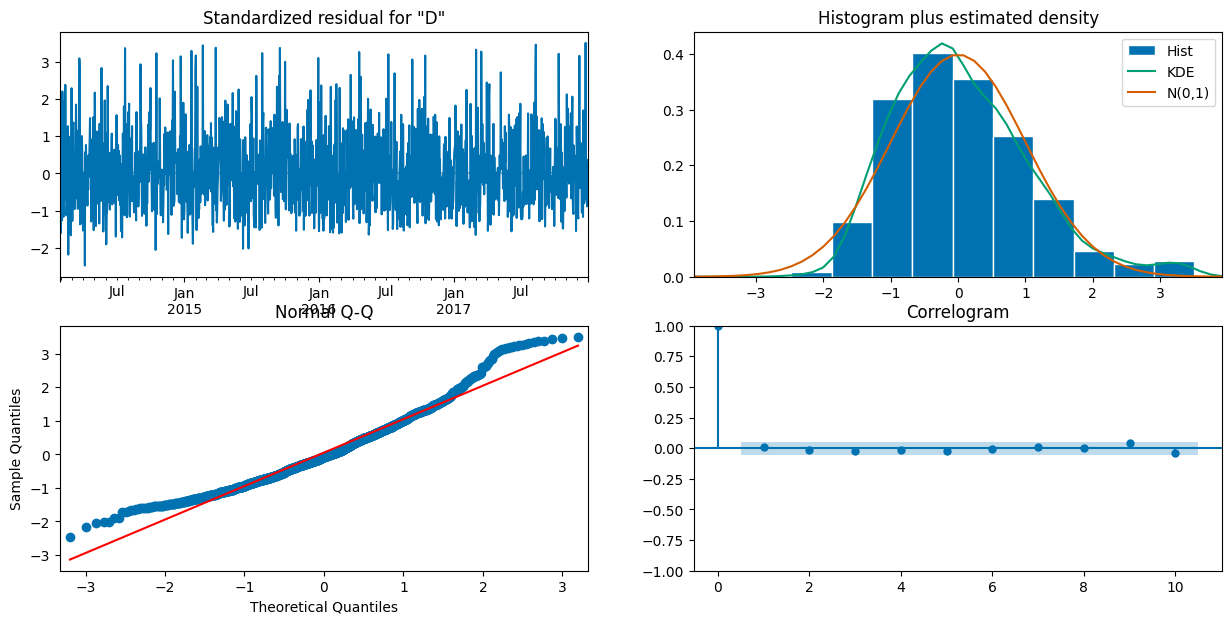

In [57]:
# Load demand data
demand_ts = pd.read_excel('https://github.com/uswatnkh07/Demand-Forcasting-And-Safety-Stock-Management/raw/main/demand_data.xlsx', index_col='Date', parse_dates=True)

# Find the best model
best_aic = float("inf")
best_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(demand_ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{};  AIC:{:.4f}'.format(param, param_seasonal, results.aic))

            # Check if current model has lower AIC than the previous best model
            if results.aic < best_aic:
                best_aic = results.aic
                best_model = results

        except Exception as e:
            print(f"Model ARIMA{param}x{param_seasonal} failed with exception: {str(e)}")
            continue

# Plot diagnostics for the best model
if best_model is not None:
    best_model.plot_diagnostics(figsize=(15, 7))

In [58]:
pred = results.get_prediction(start = pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head(10)

,lower Daily_Demand,upper Daily_Demand
2017-01-01,4.882944,15.053391
2017-01-02,5.520294,15.690713
2017-01-03,5.351394,15.521786
2017-01-04,4.989370,15.159736
2017-01-05,5.335396,15.505736
2017-01-06,5.221146,15.391459
2017-01-07,5.305217,15.475505
2017-01-08,5.620340,15.790609
2017-01-09,5.485108,15.655002
2017-01-10,5.029587,15.199442


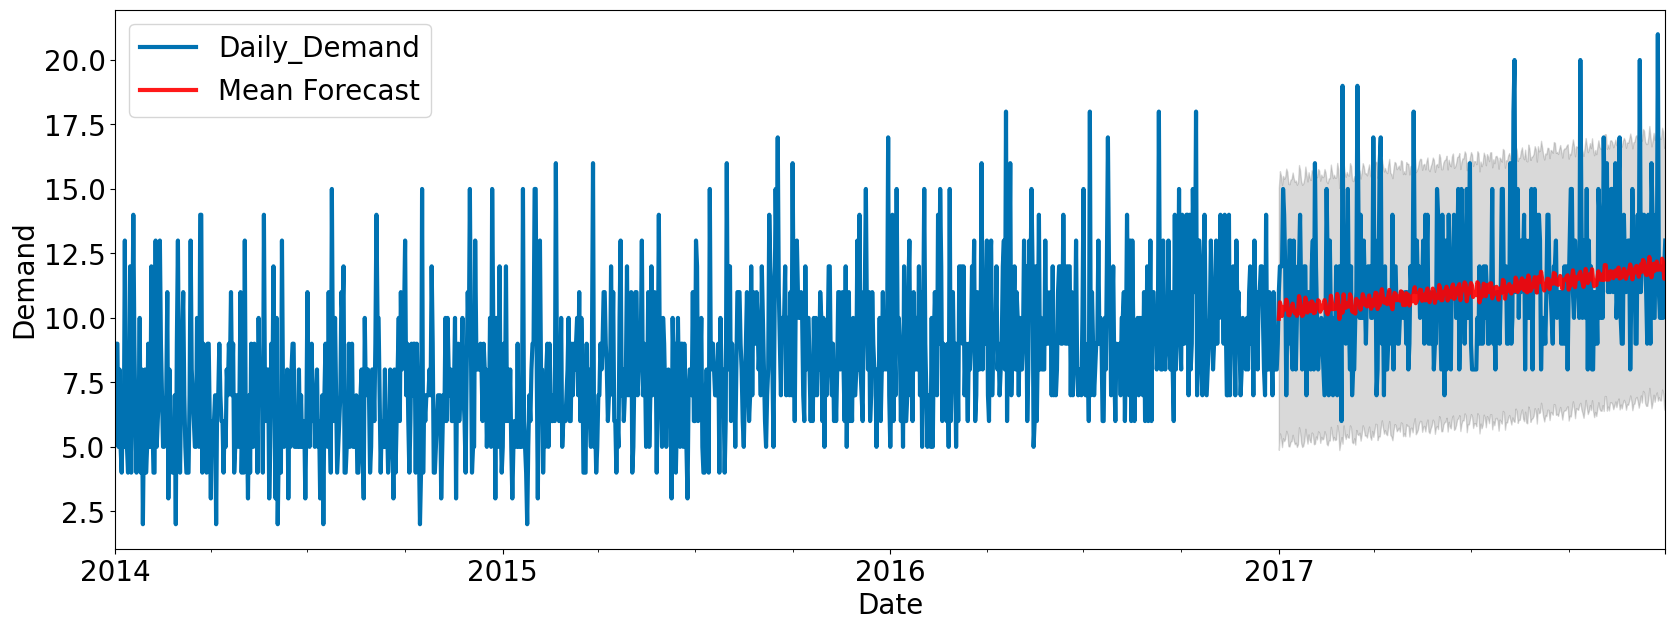

In [59]:
ax = demand_ts['2014':].plot(label='Observed', linewidth = 3, figsize=(20, 7))
pred.predicted_mean.plot(ax=ax, label='Mean Forecast', linewidth = 3, alpha=0.9, color = 'r')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.15)

ax.set_xlabel('Date', fontsize = 20)
ax.set_ylabel('Demand', fontsize = 20)
plt.legend(loc = 'upper left', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('forecast1.png',  dpi = 300)
plt.show()

In [60]:
# Get forecast 12 months ahead in future
forcast_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
forcast_ci = forcast_uc.conf_int()
forcast_ci.head(10)

,lower Daily_Demand,upper Daily_Demand
2018-01-01,7.064997,17.220160
2018-01-02,6.979357,17.137682
2018-01-03,7.038761,17.197246
2018-01-04,7.232377,17.390795
2018-01-05,6.624348,16.782896
2018-01-06,6.753450,16.912129
2018-01-07,6.788175,16.946987
2018-01-08,6.939028,17.097974
2018-01-09,7.302382,17.461461
2018-01-10,7.104922,17.264135


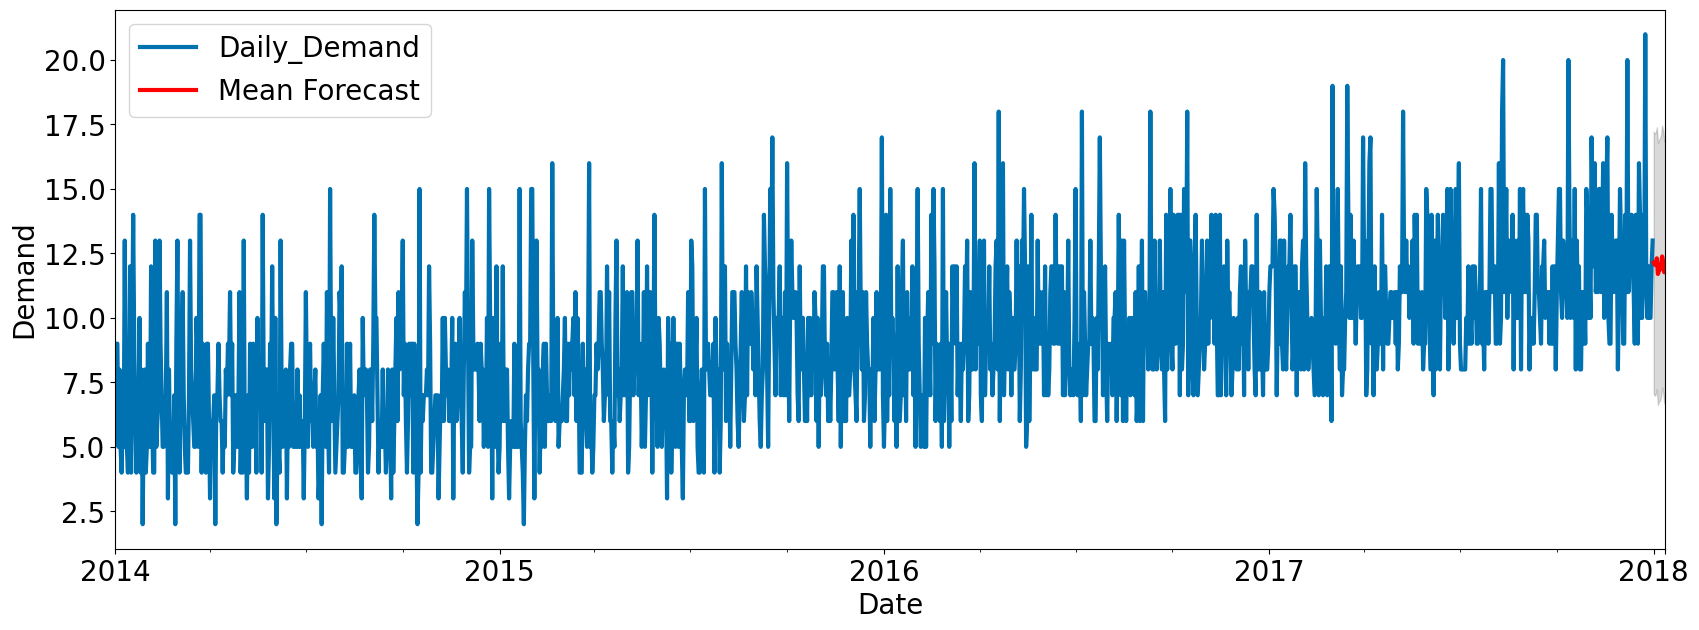

In [61]:
ax = demand_ts.plot(label='Observed', linewidth = 3, figsize=(20, 7))
forcast_uc.predicted_mean.plot(ax=ax, label='Mean Forecast', linewidth = 3,color = 'r')
ax.fill_between(forcast_ci.index,
                forcast_ci.iloc[:, 0],
                forcast_ci.iloc[:, 1], color='k', alpha=.15)
ax.set_xlabel('Date', fontsize=20)
ax.set_ylabel('Demand', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc = 'upper left', fontsize=20)
plt.savefig('forecast2.png',  dpi = 300)
plt.show()

### Find the Mean and Standard Deviation of the forcast demand

Aturan jangkauan untuk Standar Deviasi:
$\,\,\,\sigma \approx \dfrac{max - min}{4}$

In [62]:
demand_forcast = forcast_ci.copy()
demand_forcast['Mean_Daily_Demand'] = demand_forcast[['lower Daily_Demand', 'upper Daily_Demand']].mean(axis=1)
demand_forcast['Std_Daily_Demand'] = \
demand_forcast.apply(lambda x: (x['upper Daily_Demand'] - x['lower Daily_Demand'])/4, axis=1)
demand_forcast

,lower Daily_Demand,upper Daily_Demand,Mean_Daily_Demand,Std_Daily_Demand
2018-01-01,7.064997,17.220160,12.142578,2.538791
2018-01-02,6.979357,17.137682,12.058520,2.539581
2018-01-03,7.038761,17.197246,12.118004,2.539621
2018-01-04,7.232377,17.390795,12.311586,2.539605
2018-01-05,6.624348,16.782896,11.703622,2.539637
2018-01-06,6.753450,16.912129,11.832790,2.539670
2018-01-07,6.788175,16.946987,11.867581,2.539703
2018-01-08,6.939028,17.097974,12.018501,2.539736
2018-01-09,7.302382,17.461461,12.381921,2.539770
2018-01-10,7.104922,17.264135,12.184529,2.539803


<h2><center>Safety Stock Optimization</center></h2>

In [63]:
# Lead time data from file
leadtime_df = pd.read_csv("https://raw.githubusercontent.com/uswatnkh07/Demand-Forcasting-And-Safety-Stock-Management/main/lead_time.csv")
leadtime_list = leadtime_df["lead_time"].tolist()
leadtime_list[:20]

[1, 3, 3, 1, 1, 3, 3, 1, 4, 3, 1, 3, 4, 4, 4, 4, 4, 1, 5, 3]

Perhitungan rata-rata dan standar deviasi dari lead time: ($\mu_L$ and $\sigma_L$) :

In [64]:
from statistics import mean, stdev

mu_L = mean(leadtime_list)
sigma_L = stdev(leadtime_list)

print('Mean of lead time = {:.3f}'.format(mu_L))
print('Standard Deviation of lead time = {:.3f}'.format(sigma_L))

Mean of lead time = 3.019
Standard Deviation of lead time = 1.306


Rata-rata dan standar deviasi permintaan: ($\mu_D$ and $\sigma_D$) :

In [65]:
mu_D = demand_forcast['Mean_Daily_Demand'].tolist()
sigma_D = demand_forcast['Std_Daily_Demand'].tolist()

## Statistics of lead-time demand:
Permintaan lead time $D_L$, yang merupakan variabel acak baru diberikan oleh
$$D_L = \sum_{i=1}^{L}D_i$$
akan mengikuti distribusi normal dengan rata-rata dan varians yang diberikan oleh

$$\mathbb{E}[D_L] = \mathbb{E}\left[\sum_{i=1}^{L}D_i\right] = \mu_L\mu_D, \,\,\,\,Var[D_L] = \mathbb{E}\left[\sum_{i=1}^{L}D_i\right] = \mu_L\sigma_D^2+\mu_D^2\sigma_L^2$$

yaitu:

$$D_L\sim\mathcal{N}(\mu_L\mu_D,\, \mu_L\sigma_D^2+\mu_D^2\sigma_L^2)$$

Economic Order Quantity (EOQ):
----
EOQ dihitung menggunakan rumus berikut:

$$EOQ = \sqrt{\left(\frac{2\mu_Lc_0}{c_h}\right)}$$

dimana,

$\mu_D = $ Nilai rata-rata permintaan harian,

$c_0 = $ Biaya pemesanan tetap per pesanan,

$c_h = $ Biaya penyimpanan per satuan kuantitas per unit waktu

2018-Jan: EOQ = 54
2018-Feb: EOQ = 54
2018-Mar: EOQ = 54
2018-Apr: EOQ = 54
2018-May: EOQ = 53
2018-Jun: EOQ = 53
2018-Jul: EOQ = 53
2018-Aug: EOQ = 54
2018-Sep: EOQ = 55
2018-Oct: EOQ = 54
2018-Nov: EOQ = 53
2018-Dec: EOQ = 54


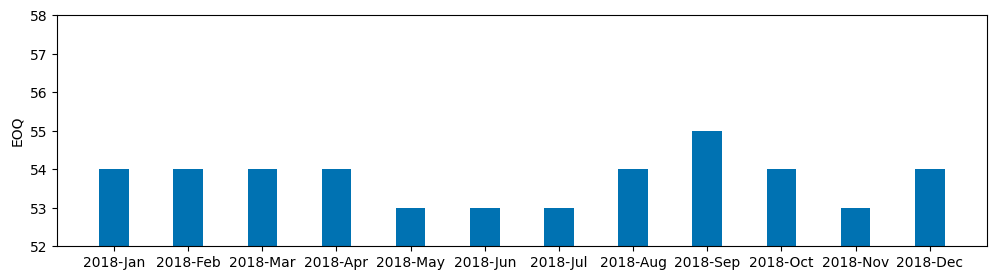

In [70]:
c0 = 12000  # Fixed ordering cost per order
ch = 100  # Holding cost per unit per unit time

EOQ = []

# Tentukan rentang tanggal yang sesuai untuk pd.date_range
start_date = '2018-01-01'
end_date = '2018-12-01'

datelist = pd.date_range(start=start_date, end=end_date, freq='MS').strftime("%Y-%b").tolist()

# Memeriksa panjang datelist dan mu_D
if len(datelist) != len(mu_D):
    print("Panjang datelist ({}) dan mu_D ({}) tidak sesuai.".format(len(datelist), len(mu_D)))
else:
    for i, mean_demand_i in enumerate(mu_D):
        EOQ.append(round(sqrt(2 * mean_demand_i * c0 / ch)))
        print("{}: EOQ = {}".format(datelist[i], EOQ[-1]))

    plt.figure(figsize=(12, 3))
    plt.bar(np.arange(len(datelist)), EOQ, width=0.4)
    plt.xticks(np.arange(len(datelist)), datelist)
    plt.ylim(52, 58)
    plt.ylabel('EOQ')
    plt.savefig('EOQ.png', dpi=300)


## Calculation of Reorder point (ROP) and Safety Stock (SS) for $\,P(\text{No stock-out}) = 1 - \alpha$
Untuk $ (1-\alpha) $ tingkat layanan, rumus untuk **safey stock (SS)** diberikan oleh:

$$SS = z_{\alpha}\,Var[D_L] = z_{\alpha}\sqrt{\mu_L\sigma_D^2+\mu_D^2\sigma_L^2}$$

dimana $z_{\alpha}$ dihitung dengan hubungan:

$$Prob\,(z\geq z_{\alpha})=\alpha\,\,\, \text{ where }z\sim\mathcal{N}(0,1)$$<br>

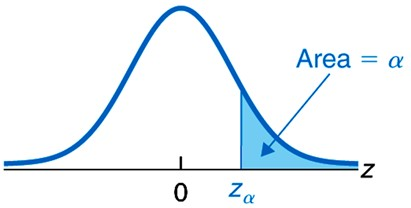

Setelah stok safety stock (SS) dihitung, **reorder point (ROP)** kemudian diberikan oleh:<br>

$$ROP = \mathbb{E}[D_L]+SS$$

$$=\mu_L\mu_D+z_{\alpha}\sqrt{\mu_L\sigma_D^2+\mu_D^2\sigma_L^2}$$

In [71]:
alpha_list = np.linspace(0.90, 0.99, 10)
print(alpha_list)

[0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]


In [72]:
SS = [[]]*len(datelist)
ROP = [[]]*len(datelist)
for i, (mean_demand_i, std_demand_i) in enumerate(zip(mu_D, sigma_D)):
    SS_row_i = []
    ROP_row_i = []
    D_L = mean_demand_i*mu_L
    for alpha in alpha_list:
        z_value = norm.ppf(alpha)
        SS_value = z_value*sqrt(mu_L*(std_demand_i**2) + (mean_demand_i**2)*(sigma_L**2))
        SS_row_i.append(round(SS_value))

        # Reorder point (ROP) = Expected demand during lead time (D_L) + Safety stock (SS)
        ROP_row_i.append(round(D_L + SS_value))

    SS[i] = SS_row_i
    ROP[i] = ROP_row_i

In [73]:
# Safety stock (SS)
SS_df = pd.DataFrame(SS)
SS_df.columns = [r'$\alpha$ = {:.2f}'.format(x) for x in alpha_list]
SS_df.index = datelist
SS_df

,$\alpha$ = 0.90,$\alpha$ = 0.91,$\alpha$ = 0.92,$\alpha$ = 0.93,$\alpha$ = 0.94,$\alpha$ = 0.95,$\alpha$ = 0.96,$\alpha$ = 0.97,$\alpha$ = 0.98,$\alpha$ = 0.99
2018-Jan,21,22,23,24,26,27,29,31,34,38
2018-Feb,21,22,23,24,25,27,29,31,34,38
2018-Mar,21,22,23,24,26,27,29,31,34,38
2018-Apr,21,22,23,25,26,27,29,31,34,39
2018-May,20,21,22,23,25,26,28,30,33,37
2018-Jun,21,22,23,24,25,26,28,30,33,37
2018-Jul,21,22,23,24,25,27,28,30,33,37
2018-Aug,21,22,23,24,25,27,29,31,33,38
2018-Sep,21,22,24,25,26,28,29,32,34,39
2018-Oct,21,22,23,24,26,27,29,31,34,38


In [74]:
# Reorder Point (ROP)
ROP_df = pd.DataFrame(ROP)
ROP_df.columns = [r'$\alpha$ = {:.2f}'.format(x) for x in alpha_list]
ROP_df.index = datelist
ROP_df

,$\alpha$ = 0.90,$\alpha$ = 0.91,$\alpha$ = 0.92,$\alpha$ = 0.93,$\alpha$ = 0.94,$\alpha$ = 0.95,$\alpha$ = 0.96,$\alpha$ = 0.97,$\alpha$ = 0.98,$\alpha$ = 0.99
2018-Jan,58,59,60,61,62,64,65,68,70,75
2018-Feb,57,58,59,61,62,63,65,67,70,74
2018-Mar,58,59,60,61,62,64,65,67,70,75
2018-Apr,59,60,61,62,63,65,66,69,71,76
2018-May,56,57,58,59,60,62,63,65,68,72
2018-Jun,56,57,58,59,61,62,64,66,69,73
2018-Jul,56,57,58,60,61,62,64,66,69,73
2018-Aug,57,58,59,60,62,63,65,67,70,74
2018-Sep,59,60,61,62,63,65,67,69,72,76
2018-Oct,58,59,60,61,62,64,66,68,71,75


### Plotting SS and ROP in a chart

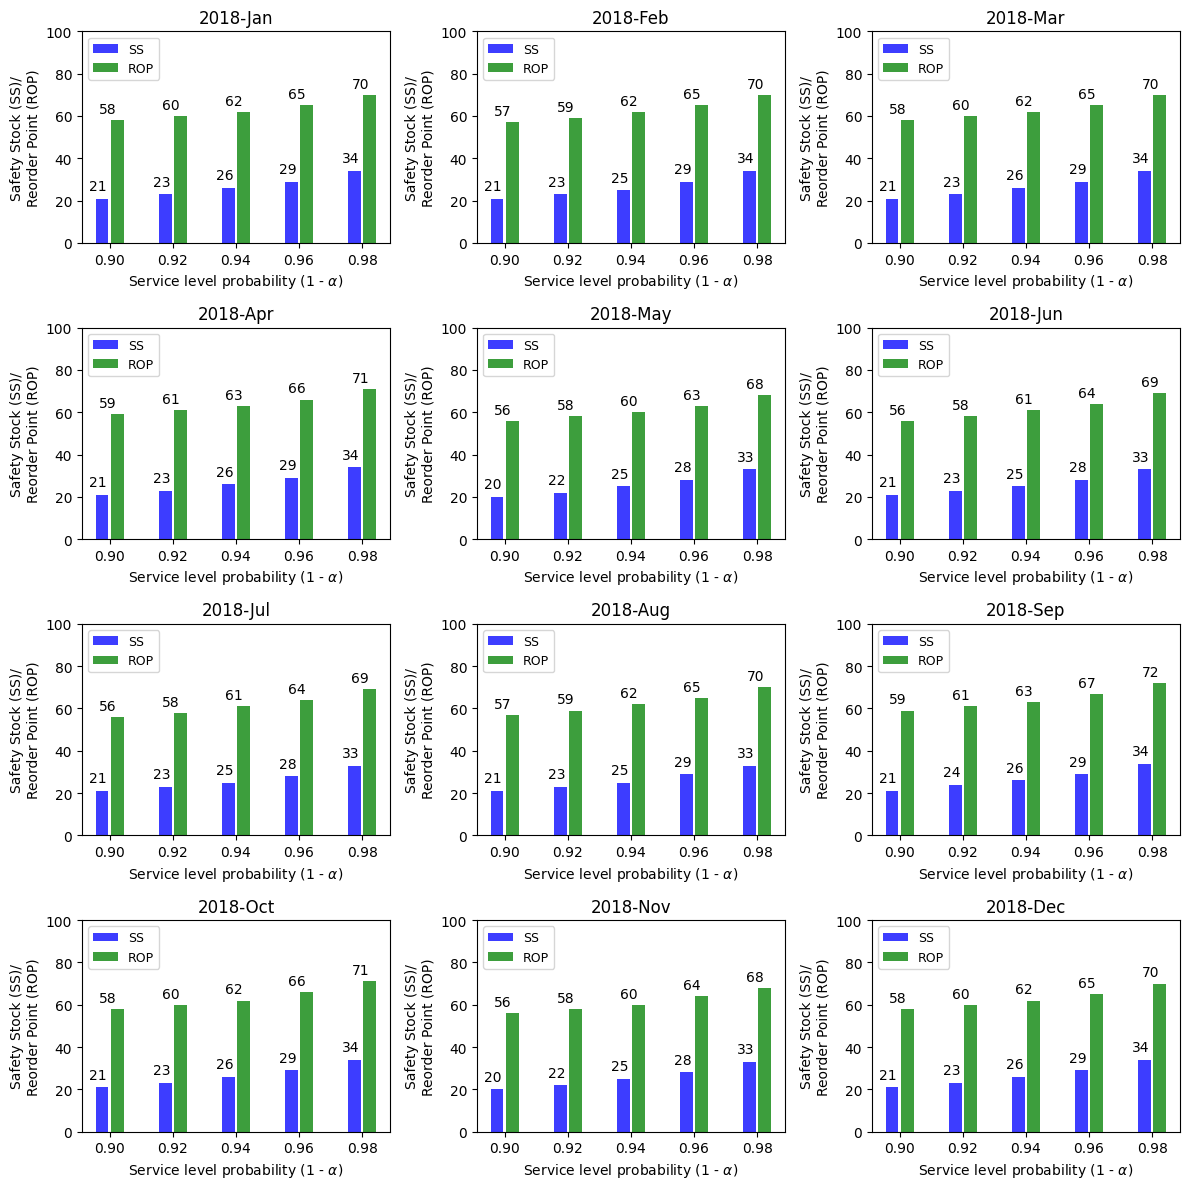

In [75]:
fig1 = plt.figure(figsize=(12, 12))

skip = 2
for i in range(len(datelist)):

    SS_monthly_list = SS_df.iloc[i,:].tolist()
    ROP_monthly_list = ROP_df.iloc[i,:].tolist()

    ax = plt.subplot(4,3,i+1)

    ax.bar(alpha_list[::skip]-0.0012*skip, SS_monthly_list[::skip], width=0.002*skip, color='b',\
           align='center', label = 'SS', alpha = 0.76)
    ax.bar(alpha_list[::skip]+0.0012*skip, ROP_monthly_list[::skip], width=0.002*skip, color='g',\
           align='center',label = 'ROP', alpha = 0.76)

    for x, y, z in zip(alpha_list[::skip], SS_monthly_list[::skip], ROP_monthly_list[::skip]):
        plt.annotate(y, xy=(x, y), xytext=(-2, 4),\
            textcoords='offset points', ha='right', va='bottom')
        plt.annotate(z, xy=(x, z), xytext=(5, 3),\
            textcoords='offset points', ha='right', va='bottom')

    plt.xlabel('Service level probability (1 - $\\alpha$)', fontsize = 10)
    plt.ylabel('Safety Stock (SS)/'+'\n'+'Reorder Point (ROP)', fontsize = 10)
    plt.ylim(0, 100)
    plt.legend(loc = 'upper left', fontsize = 9)
    ax.set_title(datelist[i])

plt.tight_layout()
plt.show()

**Perbedaan antara Safety Stock dan Reorder Point (ROP):**



*   **Perbedaan Berdasarkan Fungsinya:** Reorder Point (ROP) menunjukkan titik minimum persediaan di mana Anda perlu memesan ulang barang untuk menghindari kehabisan stok. Sedangkan, safety stock adalah persediaan tambahan yang disimpan sebagai cadangan untuk mengatasi ketidakpastian dan fluktuasi permintaan.

*   **Perbedaan Berdasarkan Cara Menghitungnya:** Reorder Point dihitung berdasarkan permintaan rata-rata, lead time, dan tingkat keamanan persediaan. Safety stock biasanya dihitung dengan mempertimbangkan faktor-faktor seperti deviasi standar permintaan, lead time maksimum, dan tingkat layanan pelanggan yang diinginkan.


